In [1]:
import os
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
start_date='2022-02-01'
end_date='2022-12-31'
stocks=['GOOG','MSFT']
df=yf.download(stocks,start=start_date,end=end_date)['Adj Close']
df

[*********************100%***********************]  2 of 2 completed


,GOOG,MSFT
Date,,
2022-01-31,135.698502,306.005127
2022-02-01,137.878494,303.820648
2022-02-02,148.036499,308.445465
2022-02-03,142.650497,296.430786
2022-02-04,143.016006,301.045746
...,...,...
2022-12-23,89.809998,237.112076
2022-12-27,87.930000,235.354080
2022-12-28,86.459999,232.940552


In [3]:
#build linear regression model
#Extract prices for two stocks of interest
#target var: Y; predictor: x
Y=df[stocks[0]]
X=df[stocks[1]]
#estimate lina=ear regression coefficient of stock 1 on stock2
X_with_constant=sm.add_constant(X)
model=OLS(Y,X_with_constant).fit()
residuals=Y-model.predict()
print(model.params)

const   -52.475718
MSFT      0.631940
dtype: float64


In [4]:
#alternative approach
residuals2=Y-(model.params['const']+model.params[stocks[1]]*X)

In [5]:
print(residuals.equals(residuals2))

True


In [6]:
#test residuals for stationarity
adf_test=adfuller(residuals)
print("ADF test statistics: ",adf_test[0])
print("p-values: ",adf_test[1])
if adf_test[1]<0.05:
    print('The two stocks are cointegrated')
else:
    print('The tow stocks are not cointegrated.')

ADF test statistics:  -2.9623259019880313
p-values:  0.038565632753519444
The two stocks are cointegrated


In [7]:
#dowload data from yfinance
stocks=['GOOG','MSFT','AAPL','TSLA','META','NFLX']
df=yf.download(stocks,start=start_date,end=end_date)['Adj Close']
df.head()

[*********************100%***********************]  6 of 6 completed


,AAPL,GOOG,META,MSFT,NFLX,TSLA
Date,,,,,,
2022-01-31,173.033234,135.698502,313.260010,306.005157,427.140015,312.239990
2022-02-01,172.864929,137.878494,319.000000,303.820648,457.130005,310.416656
2022-02-02,174.082642,148.036499,323.000000,308.445435,429.480011,301.886658
2022-02-03,171.172012,142.650497,237.759995,296.430786,405.600006,297.046661
2022-02-04,170.884552,143.016006,237.089996,301.045746,410.170013,307.773346


In [8]:
from itertools import combinations
stock_pairs=list(combinations(df.columns,2))
stock_pairs

[('AAPL', 'GOOG'),
 ('AAPL', 'META'),
 ('AAPL', 'MSFT'),
 ('AAPL', 'NFLX'),
 ('AAPL', 'TSLA'),
 ('GOOG', 'META'),
 ('GOOG', 'MSFT'),
 ('GOOG', 'NFLX'),
 ('GOOG', 'TSLA'),
 ('META', 'MSFT'),
 ('META', 'NFLX'),
 ('META', 'TSLA'),
 ('MSFT', 'NFLX'),
 ('MSFT', 'TSLA'),
 ('NFLX', 'TSLA')]

In [9]:
from statsmodels.tsa.stattools import coint
#calculate the correlation coefficient
#print('')

In [10]:
threshold=0.10
for pair in stock_pairs:
    #subset df based on current pair of stocks
    df2=df[list(pair)]
    #perform test for current pair of stocks
    score,pvalue,_=coint(df2.values[:,0],df2.values[:,1])
    #check if the current pair of stock is cointegrated
    if pvalue<threshold:
        print(pair,'are cointegrated')
    else:
        print(pair,'are not cointegrated')

('AAPL', 'GOOG') are not cointegrated
('AAPL', 'META') are not cointegrated
('AAPL', 'MSFT') are not cointegrated
('AAPL', 'NFLX') are not cointegrated
('AAPL', 'TSLA') are cointegrated
('GOOG', 'META') are cointegrated
('GOOG', 'MSFT') are not cointegrated
('GOOG', 'NFLX') are not cointegrated
('GOOG', 'TSLA') are not cointegrated
('META', 'MSFT') are cointegrated
('META', 'NFLX') are not cointegrated
('META', 'TSLA') are cointegrated
('MSFT', 'NFLX') are not cointegrated
('MSFT', 'TSLA') are not cointegrated
('NFLX', 'TSLA') are not cointegrated


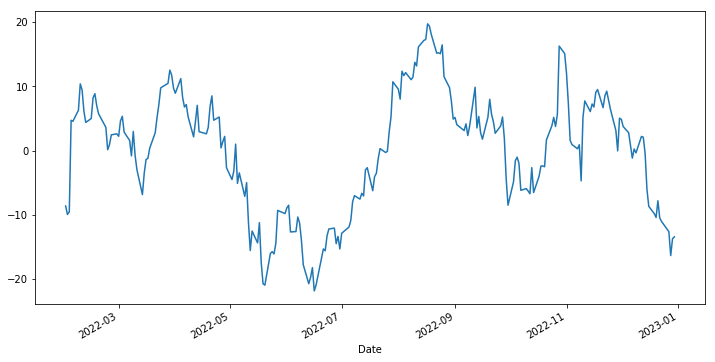

In [11]:
Y=df['AAPL']
X=df['META']
#Estimate linear regression coeffiecients
X_with_constant=sm.add_constant(X)
model=OLS(Y,X_with_constant).fit()
#obtain the spread as residuals
spread=Y-model.predict()
spread.plot(figsize=(12,6))

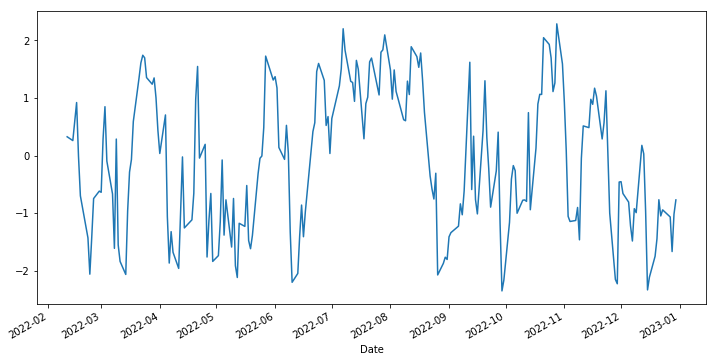

In [12]:
#convert to Z score
#Z-score is measure of how many standar deviations the is from its mean
#derive mean and sd using a moving window
window_size=10
spread_mean=spread.rolling(window=window_size).mean()
spread_std=spread.rolling(window=window_size).std()
zscore=(spread-spread_mean)/spread_std
zscore.plot(figsize=(12,6))

In [13]:
first_valid_idx=zscore.first_valid_index()
print(first_valid_idx)
zscore=zscore[first_valid_idx:]
first_valid_idx

2022-02-11 00:00:00


Timestamp('2022-02-11 00:00:00')

In [14]:
entry_threshold=2.0
exit_threshold=1.0

#initialize the daily positions to be zeros
stock1_position=pd.Series(data=0,index=zscore.index)
stock2_position=pd.Series(data=0,index=zscore.index)

#generate daily entry and exit signals for each stock
for i in range(0,len(zscore)):
    #Zscore<-2 and no existing long position for stock 1
    if zscore[i]<-entry_threshold and stock1_position[i-1]==0:
        stock1_position[i]=1#long stock 1
        stock2_position[i]=-1#short stock 2
        
    #Zscore< 2 and no existing long position for stock 2
    elif zscore[i]>entry_threshold and stock2_position[i-1]==0:
        stock1_position[i]=-1#short stock 1
        stock2_position[i]=1#long stock 2
    #-1<zscore<1    
    elif abs(zscore[i])<exit_threshold:
        stock1_position[i]=0 #exiting position
        stock2_position[i]=0
    #-2<zscore<-1 or 1<zscore<2
    else:
        stock1_position[i]=stock1_position[i-1]
        stock2_position[i]=stock2_position[i-1]

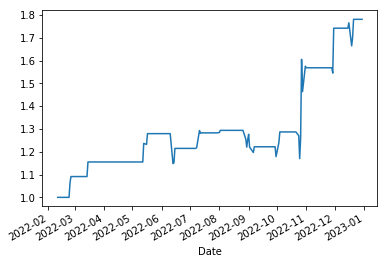

In [15]:
#Calculate the return of each stock
stock1_returns=(df['AAPL'][first_valid_idx:].pct_change()*stock1_position.shift(1)).fillna(0)
stock2_returns=(df['META'][first_valid_idx:].pct_change()*stock1_position.shift(1)).fillna(0)
total_returns=stock1_returns+stock2_returns
cumulative_returns=(1+total_returns).cumprod()
#plot the cumulative return
cumulative_returns.plot()

In [16]:
cumulative_returns[-1]-1

0.7812392042954168

In [17]:
stock1_position[stock1_position==-1]

Date
2022-07-07   -1
2022-07-08   -1
2022-07-11   -1
2022-07-12   -1
2022-07-29   -1
2022-08-01   -1
2022-10-21   -1
2022-10-24   -1
2022-10-25   -1
2022-10-26   -1
2022-10-27   -1
2022-10-28   -1
2022-10-31   -1
dtype: int64

In [18]:
stock2_position[stock2_position==1]

Date
2022-07-07    1
2022-07-08    1
2022-07-11    1
2022-07-12    1
2022-07-29    1
2022-08-01    1
2022-10-21    1
2022-10-24    1
2022-10-25    1
2022-10-26    1
2022-10-27    1
2022-10-28    1
2022-10-31    1
dtype: int64